### Cab-Driver Agent

In [12]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import pylab
# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [13]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [14]:
env = CabDriver()

#### Tracking the state-action pairs for checking convergence


In [15]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [16]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001   
        self.epsilon = 1.0
        self.epsilon_decay = 0.0100
        self.epsilon_min = 0.08
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        self.train_start = 100
        
        # Initialize the value of the states tracked
        self.states_tracked = []

        #Track for 1, 0, 0 state
        self.track_state = np.array(env.state_encod_arch1([1,0,0])).reshape(1, 36)
        # create main model and target model
        self.model = self.build_model()
        #build target model
        self.target_model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def get_action(self, state,possible_actions_index):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # possible actions list would be given by environment
            return random.choice(possible_actions)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]
        

    def append_sample(self, state, action_index, reward, next_state,done):
        # append the tuple (s, a, r, s', done) to memory (replay buffer) after every action
        self.memory.append((state, action_index, reward, next_state, done))
    
       
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) < self.train_start:
            return

        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)

        update_output = np.zeros((self.batch_size, self.state_size))
        update_input = np.zeros((self.batch_size, self.state_size))
        
        actions, rewards, done = [], [],[]
        
        for i in range(self.batch_size):
            state, action, reward, next_state,done_boolean = mini_batch[i]
            update_input[i] = env.state_encod_arch1(state)    
            actions.append(action)
            rewards.append(reward)
            update_output[i] = env.state_encod_arch1(next_state)
            done.append(done_boolean)
        # Write your code from here
        # 1. Predict the target from earlier model
        target = self.model.predict(update_input)
            
        # 2. Get the target for the Q-network
        target_qval = self.target_model.predict(update_output)  
            
        #3. Update your 'update_output' and 'update_input' batch
        for i in range(self.batch_size):
            if done[i]:
                target[i][actions[i]] = rewards[i]
            else: # non-terminal state
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
        # 4. Fit your model and track the loss values
        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save(self, name):
        self.model.save(name)

    def update_target_model(self):
        # update the target Q-value network to current Q-value network after training for a episode. 
        # this means that weights an biases of target Q-value network will become same as current Q-value network.
        self.target_model.set_weights(self.model.get_weights())        

In [17]:
Episodes = 1000

### DQN block

Episode: 50   score: 504.0   memory length: 2000   epsilon: 0.6187772039722228
Episode: 100   score: 820.0   memory length: 2000   epsilon: 0.3753073457404111
Episode: 150   score: 1132.0   memory length: 2000   epsilon: 0.2276354120069289
Episode: 200   score: 1244.0   memory length: 2000   epsilon: 0.13806785661851972
Episode: 250   score: 1118.0   memory length: 2000   epsilon: 0.08374238815994005
Episode: 300   score: 1548.0   memory length: 2000   epsilon: 0.07965822369569515
Episode: 350   score: 1459.0   memory length: 2000   epsilon: 0.07965822369569515
Episode: 400   score: 1647.0   memory length: 2000   epsilon: 0.07965822369569515
Episode: 450   score: 1716.0   memory length: 2000   epsilon: 0.07965822369569515
Episode: 500   score: 1721.0   memory length: 2000   epsilon: 0.07965822369569515
Episode: 550   score: 1586.0   memory length: 2000   epsilon: 0.07965822369569515
Episode: 600   score: 1771.0   memory length: 2000   epsilon: 0.07965822369569515
Episode: 650   score: 

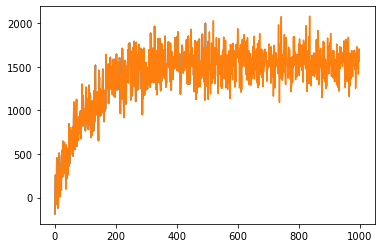

In [18]:
state = env.state_init
state_encoded = env.state_encod_arch1(state)

state_size = len(state_encoded)
action_size = len(env.action_space)
agent = DQNAgent(state_size, action_size)
scores, episodes = [], []
states_track = collections.defaultdict(dict)
episode_time = 24*30

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    
    score = 0
    done = False
    reward = 0
    env = CabDriver()
    #Call the DQN agent
    action_space, state_space, state = env.reset()
    total_time = 0
    initial_state = env.state_init

    while done==False:
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss

        # get possible list of actions from the environment
        possible_actions, action_list = env.requests(state)

        # pick epsilon-greedy action from possible actions for the current state
        # possible actions is given by the environment
        action = agent.get_action(state, possible_actions)
        
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)

        total_time += step_time
        
        # 5. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state, done)
        # 6. Train the model by calling function agent.train_model
        agent.train_model()

        #if we exceed time then terminate episode
        if (total_time > episode_time):
            done = True
        else:
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    agent.update_target_model()
    
    scores.append(score)
    episodes.append(episode)
            

    # this is track q-value convergence
    # once the episode is complete, q-values will be predicted for all possible actions for the initial state
    # this way is much easier to track because other states would be difficult to track as it is heavily dependant on the location and action taken
    
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()
    
    if((episode+1)%50==0):
        print("Episode:", episode + 1, "  score:", score, "  memory length:", len(agent.memory), "  epsilon:", agent.epsilon)
    
    #save the graph, model (h5, pickle file)
    if (episode + 1) % 500 == 0:
        pylab.plot(episodes, scores)
        pylab.savefig("cardriver_dqn_" + str(score) + ".png")
        agent.save("cardriver_dqn_" + str(score) + ".h5")
        #agent.save_model_graph(str(score))
        # this is the only one required for assignment. this will create pickle file
        save_obj(agent.model.get_weights(), "cardriver_dqn_" + str(score))

    # decay in ε after we generate each sample from the environment
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon =agent.epsilon = (1 - 0.00001) * np.exp(-agent.epsilon_decay * episode)
       

### Tracking Convergence

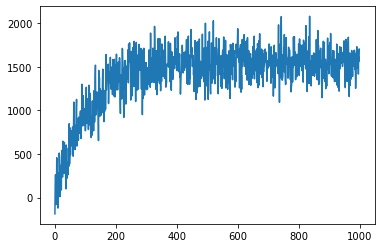

In [19]:
# convergence with scores
plt.plot(episodes, scores)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

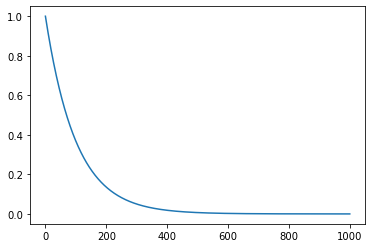

In [22]:
import numpy as np
time = np.arange(0,1000)
epsilon = []
for i in range(0,1000):
    epsilon.append(0 + (1 - 0.00001) * np.exp(-0.0100*i))

plt.plot(time, epsilon)
plt.show()